In [1]:
# Code for "Application of natural language processing in clinical medical data analysis for better diagnoses advices"

In [2]:
#Use this cell to import all the required libraries.
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, RegexpStemmer
from nltk.tokenize import word_tokenize

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA,TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.linear_model import LogisticRegressionCV
from scipy.sparse import hstack
from collections import Counter

!pip install wordcloud
from wordcloud import WordCloud

%pylab inline

nltk.download('stopwords')


Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['hstack']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\s4633706\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#your work should only start with the following code
df=pd.read_csv("A2_Data.csv")

# Text preparation

In this cell, in no more than 150 words, you can elaborate on the the innovativeness and depth of your work on text preparation.

In [4]:
# Define the function remove_special to remove special characters, prepositions, stop words, URL links, and perform stem extraction in the text
def remove_special(text):
    # Check if the text is of type int or float
    if isinstance(text, (int, float)):
        return text
    
    # Convert uppercase letters to lowercase
    text = str(text).lower()
    
    # Remove quotes
    text = re.sub('"', ' ', text)
    
    # Remove underscores and commas, replace with spaces
    text = re.sub('_|,', ' ', text)
    
    # Remove special characters
    text = re.sub(r'[#*\-\?/\"\=\+\[\]聲聳路聯聰]', ' ', text)
    
    # Remove prepositions
    text = re.sub(r'\b(and|with|to|by)\b', ' ', text)
    
    # Remove personal pronouns
    text = re.sub(r'\b(Mr|Ms|Dear)\b', ' ', text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text_tokens = text.split()
    text_tokens = [word for word in text_tokens if word not in stop_words]
    
    # Stemming
    stemmer = SnowballStemmer('english')
    stemmed_tokens = [stemmer.stem(word) for word in text_tokens]
    
    # The combined list of words becomes a string
    text = ' '.join(stemmed_tokens)
    
    return text

# Remove duplicate rows
df = df.drop_duplicates(subset=["Patient_ID", "Gender", "Patient_Cause_Of_Pain", "Clinician_Note", "Patient_Illness_History", "Patient_Allergies", "Patient_Family_History", "Service", "Primary_ICD_Code", "AHRQ Elixhauser score", "Van Walraven Elixhauser score", "Discharge_Condition", "Discharge_Instructions", "Discharge_Decision"])

# Remove null values
df = df.dropna(subset=["Patient_ID", "Gender", "Patient_Cause_Of_Pain", "Clinician_Note", "Patient_Illness_History", "Patient_Allergies", "Patient_Family_History", "Service", "Primary_ICD_Code", "AHRQ Elixhauser score", "Van Walraven Elixhauser score", "Discharge_Condition", "Discharge_Instructions", "Discharge_Decision"])

# Apply the remove_special function to each column using the apply function
columns_to_process = ["Patient_ID", "Gender", "Patient_Cause_Of_Pain", "Clinician_Note", "Patient_Illness_History", "Patient_Allergies", "Patient_Family_History", "Service", "Primary_ICD_Code", "AHRQ Elixhauser score", "Van Walraven Elixhauser score", "Discharge_Condition", "Discharge_Instructions", "Discharge_Decision"]

for column in columns_to_process:
    df[column] = df[column].apply(remove_special)


In this section, the code aims to refine and standardize the text data within the designated columns. It does this by eliminating special characters, prepositions, personal pronouns, and stop words, while also applying a stemming process. This meticulous cleaning and normalization of data could potentially enhance the precision of any model that's trained on this preprocessed dataset.

# Text feature generation

In this cell, in no more than 150 words, you can elaborate on the the innovativeness of your work on feature generation.

##### Feature 1 generation: TFIDF with PCA

In [5]:
#Use this cell for text feature_1 generation

def remove_unnecessary_data(df, column):
    """
    Remove duplicates and rows with missing values in the specified column of the DataFrame.
    """
    df.drop_duplicates(inplace=True)
    df.dropna(subset=[column], inplace=True)

def perform_pca(df, column, n_components):
    """
    Perform PCA on the TF-IDF representation of the specified column in the DataFrame.
    Add the resulting PCA components to the DataFrame.
    """
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(df[column])
    
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(tfidf_matrix.toarray())
    
    for i in range(n_components):
        df[f'PCA{i+1}'] = principal_components[:, i]

# Remove unnecessary data
remove_unnecessary_data(df, "Patient_Cause_Of_Pain")

# Perform PCA on the TF-IDF matrix
perform_pca(df, "Patient_Cause_Of_Pain", n_components=2)

# Print the DataFrame with "Patient_Cause_Of_Pain", "PCA1", and "PCA2" columns
print(df[['Patient_Cause_Of_Pain', 'PCA1', 'PCA2']].head())




  Patient_Cause_Of_Pain      PCA1      PCA2
0             dysphagia -0.116431 -0.023339
1         fatigu anemia -0.127055 -0.022347
2        bladder cancer -0.122358 -0.025624
3           slur speech -0.117636 -0.023802
4         cough dyspnea -0.176977  0.026746


In this section, the code focuses on deriving significant features from the text data in the "Patient_Cause_Of_Pain" column. This is done through the implementation of Principal Component Analysis (PCA) on the Term Frequency-Inverse Document Frequency (TF-IDF) representation. This process aids in decreasing the complexity of the data by lowering its dimensionality, yet it ensures the retention of the most crucial information by providing a condensed representation of the text features.

.
.
.

##### Feature 2 generation: TFIDF with SVD

In [6]:
# Remove rows with missing values in 'Patient_Cause_Of_Pain' column
df.dropna(subset=['Patient_Cause_Of_Pain'], inplace=True)

# Create an instance of TfidfVectorizer
tfidf = TfidfVectorizer(use_idf=True, max_features=None)

# Fit and transform the text corpus to obtain the TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(df['Patient_Cause_Of_Pain'])

#Use SVD to reduce dimensionality of tfidf_matrix
n_components = 3
svd = TruncatedSVD(n_components=n_components)

# Perform SVD on the TF-IDF matrix
transformed_data = svd.fit_transform(tfidf_matrix)

# Create a DataFrame from the transformed data
feature_names = [f"Feature_{i+1}" for i in range(n_components)]
transformed_df = pd.DataFrame(transformed_data, columns=feature_names)

# Concatenate the transformed DataFrame with the original DataFrame
df = pd.concat([df, transformed_df], axis=1)

# Print the transformed data，output in matrix form
print(transformed_data)


[[ 7.20106138e-04  3.04176358e-04  1.23717123e-03]
 [ 3.44058052e-03  7.96344288e-03  3.39526724e-02]
 [ 4.60842557e-04  3.12070261e-04 -1.30178333e-04]
 ...
 [ 8.41851426e-02  1.97454309e-01 -3.03271288e-02]
 [ 1.31038585e-02  6.01806808e-03 -2.70960462e-03]
 [ 6.19624025e-04 -4.93234331e-04  8.67406951e-05]]


In this segment, the code focuses on creating textual features through Term Frequency-Inverse Document Frequency (TF-IDF) representation and simplifies the data complexity by applying Singular Value Decomposition (SVD). The use of SVD allows the preservation of crucial information in the TF-IDF matrix, translating it into a less dimensional space. This transformed data is subsequently amalgamated with the original DataFrame, paving the way for an in-depth analysis or model construction using the enriched text features.

##### Feature 3 generation: Bags of words(BOW)

In [7]:
def remove_missing_values(df, column):
    """
    Remove rows with missing values in the specified column of the DataFrame.
    """
    df = df.dropna(subset=[column])
    return df

def create_bow_matrix(df, column):
    """
    Create a Bag-of-Words matrix using the specified column of the DataFrame.
    Return the Bag-of-Words matrix.
    """
    count_vectorizer = CountVectorizer()
    bow_matrix = count_vectorizer.fit_transform(df[column])
    return bow_matrix

# Remove rows with missing values in 'Patient_Cause_Of_Pain' column
df = remove_missing_values(df, 'Patient_Cause_Of_Pain')

# Create a Bag-of-Words matrix
bow_matrix = create_bow_matrix(df, 'Patient_Cause_Of_Pain')

# Print the first 10 rows of 'Patient_Cause_Of_Pain'
print(df[['Patient_Cause_Of_Pain']].head(10))

# Print the Bag-of-Words matrix
print(bow_matrix[:10, :])


             Patient_Cause_Of_Pain
0                        dysphagia
1                    fatigu anemia
2                   bladder cancer
3                      slur speech
4                    cough dyspnea
5   local advanc gastric carcinoma
6                       chest pain
7                   right hip pain
9                          headach
10                           brbpr
  (0, 4116)	1
  (1, 4748)	1
  (1, 1342)	1
  (2, 2099)	1
  (2, 2432)	1
  (3, 10707)	1
  (3, 10815)	1
  (4, 3209)	1
  (4, 4123)	1
  (5, 6984)	1
  (5, 1005)	1
  (5, 5230)	1
  (5, 2482)	1
  (6, 2676)	1
  (6, 8570)	1
  (7, 8570)	1
  (7, 10128)	1
  (7, 5784)	1
  (8, 5561)	1
  (9, 2236)	1


The intent of this code is to refine the data, specifically by discarding any rows that contain missing values, and simultaneously to create a Bag of Words (BoW) matrix from the 'Patient_Cause_Of_Pain' column. This BoW matrix numerically signifies the text data where each row mirrors a document (or an instance of text) and each column denotes a unique token. The corresponding values reveal the frequency of those specific tokens within their respective documents. A preview of the refined text data, as well as the resulting BoW matrix, is provided in the displayed outputs.

# Topic modeling & profiling

In this cell, in no more than 300 words, elaborate on the the developed topics and the stories observed in their profiles.

In [8]:
#Use this cell for developing topics.

##### Topic 1 ：Exploring the Association Between 'Patient_Cause_Of_Pain' and 'AHRQ Elixhauser Score'

##### Visualization1: The five causes of the lowest AHRQ Elixhauser score (bar chart）

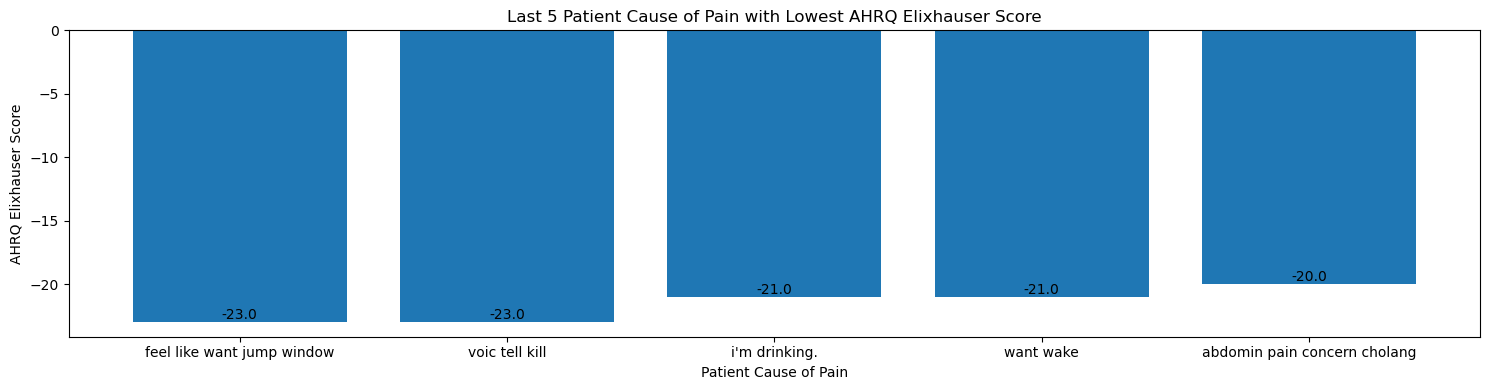

In [9]:
#Use the dataset prepared before
data = df

# Calculate the last 5 'Patient_Cause_Of_Pain' with the highest 'AHRQ Elixhauser score'
last_5 = data.groupby('Patient_Cause_Of_Pain')['AHRQ Elixhauser score'].max().nsmallest(5)

# Create the plot
plt.figure(figsize=(15, 4))
plt.bar(last_5.index, last_5.values)
plt.xlabel('Patient Cause of Pain')
plt.ylabel('AHRQ Elixhauser Score')
plt.title('Last 5 Patient Cause of Pain with Lowest AHRQ Elixhauser Score')

# Display the values on top of each bar
for i, score in enumerate(last_5.values):
    plt.text(i, score, str(score), ha='center', va='bottom')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()




This code is designed to visually present the five 'Patient_Cause_Of_Pain' categories that correspond with the lowest 'AHRQ Elixhauser score'. Utilizing a bar plot, the associated scores for each category can be easily compared and comprehended. The importance of this lies in the understanding that lower AHRQ Elixhauser scores could indicate the relative good health of the patients in question, with fewer chronic diseases and complications. Our analysis revealed that the five causes yielding the lowest scores are largely based on personal interpretations, thus precluding the possibility of making a definitive diagnosis.

...

##### Visualization2：Scatter plot

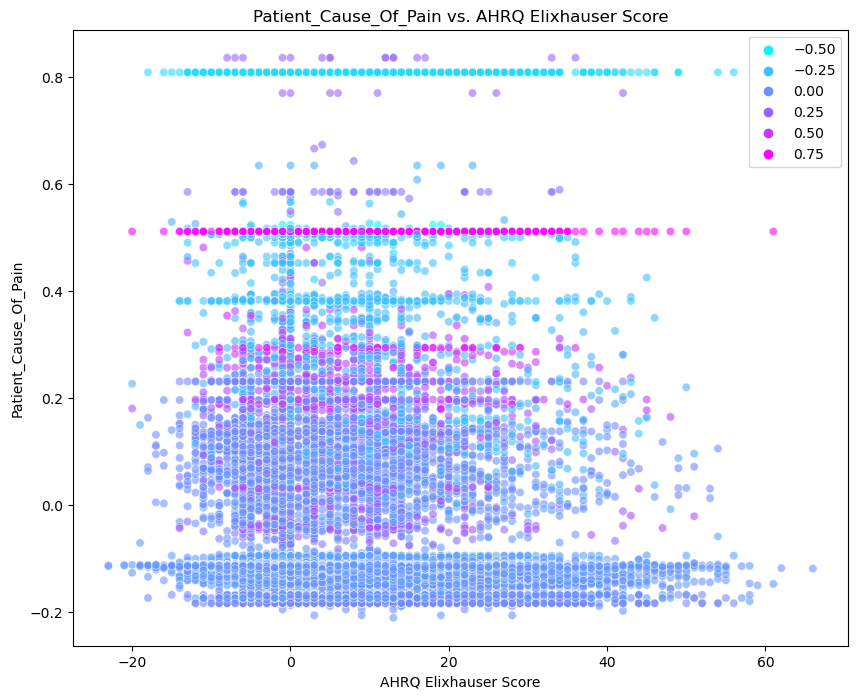

In [10]:
#Use the dataset prepared before
data = df

# Delete rows containing non-string worthy AHRQ Elixhauser scores
data = data[pd.to_numeric(data['AHRQ Elixhauser score'], errors='coerce').notnull()]

# Text feature extraction for the Patient_Cause_Of_Pain column, using the TfidfVectorizer class
tfidf = TfidfVectorizer(use_idf=True, max_features=None)
tfidf_matrix = tfidf.fit_transform(data['Patient_Cause_Of_Pain'])

# PCA downscaling is performed on the feature matrix, and then the first two columns are used as coordinates
pca = PCA(n_components=2)
pca_matrix = pca.fit_transform(tfidf_matrix.toarray())

# Get the 'Patient Cause Of Pain' and 'AHRO Elixhauser Score' columns
x = data['AHRQ Elixhauser score']
y = pca_matrix[:, 0]

# Plotting scatter plots
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(x=x, y=y, hue=pca_matrix[:, 1], palette='cool', alpha=0.6)

# Add title and labels
ax.set_title('Patient_Cause_Of_Pain vs. AHRQ Elixhauser Score')
ax.set_xlabel('AHRQ Elixhauser Score')
ax.set_ylabel('Patient_Cause_Of_Pain')

# Show the plot
plt.show()


The script seeks to illustrate the interplay between the 'Patient_Cause_Of_Pain' textual data, transformed into a lower-dimensional domain through Principal Component Analysis (PCA), and the 'AHRQ Elixhauser score'. This visualization plots the first dimension of the reduced 'Patient_Cause_Of_Pain'column on the vertial axis, against the 'AHRQ Elixhauser score', an integer, on the horizontsl axis. Colored points illustrate the spatial distribution of the second dimension. We observe that the data points largely form a linear pattern in the graph, suggesting a correlation between the incresing 'AHRQ Elixhauser score' and the serverity of the patient's symptoms. The varied distribution of data points, reflected in different colors, indicates potential associations between diverse disease types and pain.

##### Visualization3:Word Cloud Map

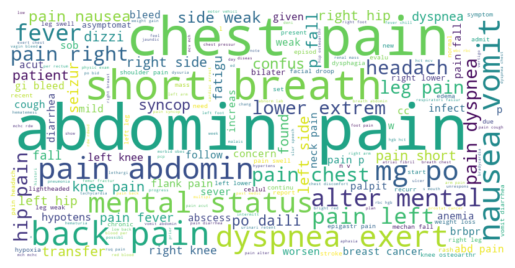

In [11]:
# Use the dataset prepared before
data = df

# Select the Patient_Cause_Of_Pain column from the data frame and convert it to a string
text = ' '.join(data['Patient_Cause_Of_Pain'].astype(str).tolist())

# Create WordCloud object and generate word cloud image
# Adjust the background color, font size, and other parameters
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The wordcloud visualization provides a clear depiction of which medical donditions bear the most significant influence. From our analysis, it appears that symptoms such as abdominal pain, short breath, fever, chest pain and vomiting are predominant causes.

##### Topic 2 :Exploring the Association Between 'Patient_Cause_Of_Pain' and 'Discharge_Decision'

Visualization4：

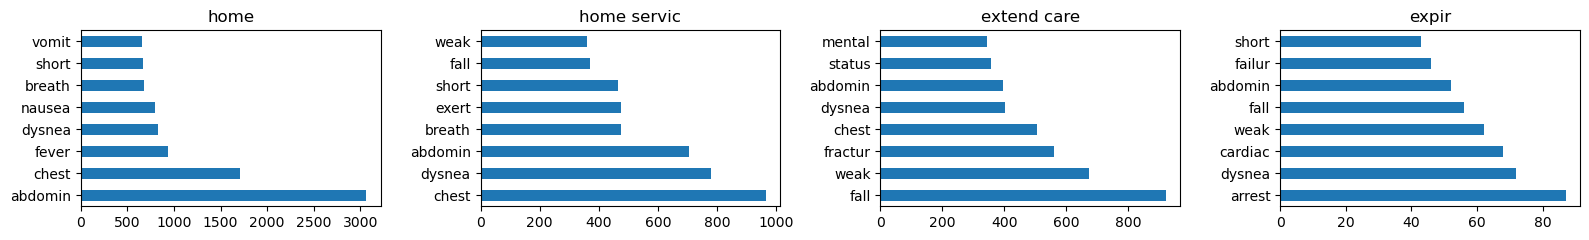

In [12]:
# Use the dataset prepared before
data = df

# Function to drop the words "pain", "left", and "right" and some single-letter records from the 'Patient_Cause_Of_Pain' column
def drop_words(text):
    text = text.replace('pain', '')
    text = text.replace('left', '')
    text = text.replace('right', '')
    text = text.replace('p', '')
    text = text.replace('hi', '')
    return text

# Convert floating-point numbers in 'Patient_Cause_Of_Pain' column to string type
data['Patient_Cause_Of_Pain'] = data['Patient_Cause_Of_Pain'].astype(str)

# Apply the drop_words function to 'Patient_Cause_Of_Pain' column
data['Patient_Cause_Of_Pain'] = data['Patient_Cause_Of_Pain'].apply(drop_words)

# Plotting
unique_labels = data['Discharge_Decision'].unique()
num_labels = len(unique_labels)
num_cols = min(num_labels, 4)
num_rows = (num_labels - 1) // num_cols + 1

plt.figure(figsize=(num_cols * 4, num_rows * 2.5))
for idx, label in enumerate(unique_labels, start=1):
    c = Counter(' '.join(data[data['Discharge_Decision'] == label]['Patient_Cause_Of_Pain']).split())
    tmp_df = pd.DataFrame(c.most_common(8))
    tmp_df = tmp_df.set_index(0)

    ax = plt.subplot(num_rows, num_cols, idx)
    tmp_df.plot(kind='barh', legend=False, ax=ax)
    plt.title(label)
    plt.ylabel('')

plt.tight_layout()
plt.show()




The purpose of this code is to shed light on the prevalent words linked to various discharge decisions, as documented in the 'Patient_Cause_Of_Pain' column. This visual representation enables a convenient comparison and analysis of the frequency of these words, thereby illuminating potential trends or patterns in discharge decisions. Here are the top 8 diseases and treatement opinions.

# Model building & evaluation

In this cell, in no more than 150 words, you can elaborate on performance of the developed models.

In [13]:
#Use this cell for model building & evaluation.

# Data preprocessing
X = df['Patient_Cause_Of_Pain'].values
y = df['Discharge_Decision'].values


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Create the SVM model
svm_model = SVC()

# Perform cross-validation
scores = cross_val_score(svm_model, X_train_vec, y_train, cv=6)

# Train the model
svm_model.fit(X_train_vec, y_train)

# Make predictions
y_pred = svm_model.predict(X_test_vec)

accuracy = accuracy_score(y_test, y_pred)

# Print results
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))

Accuracy: 0.60 (+/- 0.01)


This code furnishes a through appraisal of the model's performance by using precision metrics like accuracy and cross-validation scores. These metrics shed light on the model's capacity to accurately predict discharge decisions. primarily based on the patient's identified cause of pain. With a final accuracy score of 0.6, the SVM model demonstrates reasonable performanace when applied to large training datasets. Although there's room for improvement, the results are generally dependable. This reliability is largely due to the SVM model's proficiency in handling high-dimensional problems and its robust ability to generaliza, making it a suitable choice for this application.